In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch_geometric_temporal
import matplotlib.pyplot as plt
import torch.nn as nn
import random


print(torch.cuda.is_available())  # should print True
print(torch.version.cuda)  # should print 12.1
print(torch.cuda.get_device_name(0))  # Should print your GPU name

from torch_geometric.data import Data
from torch_geometric_temporal.signal import DynamicGraphStaticSignal
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal



True
12.1
NVIDIA GeForce GTX 960M


In [2]:
# additional things to possibly implement
#       - sinusoidal time encoding for both daily and weekly patterns
#       - one hot encoding for day of week
#       - links for distance between nodes or distance attributes in movement links (but might be already captured by node coordinates)

# things to still implement
#       - morphological node attributes
#       - weather node attributes
#       - better grouping of positions into nodes


In [3]:
#-- importing the node and position link csv files --
base_dir = 'D:/Desktop/MSc Thesis - Copy/'

nodes_df = pd.read_csv(os.path.join(base_dir, 'shapefiles/_network_parts_1/nodes_urban_feat.csv'), header = 0)
positions_links_df = pd.read_csv(os.path.join(base_dir, 'shapefiles/_network_parts_1/positions_links.csv'), header = 0)


#-- adjusting some of the imported fields --
#if there is a gemoetry column, drop it
if 'geometry' in nodes_df.columns:
    nodes_df.drop(columns=['geometry'], inplace=True) #dropping the geometry column

for col in nodes_df.select_dtypes(include=['bool']).columns: # converting boolean columnkks to integers
    nodes_df[col] = nodes_df[col].astype(int)

# converting time stamps
positions_links_df["timestamp"] = pd.to_datetime(positions_links_df["merged_datetime"], format='ISO8601')                                                   
positions_links_df["merged_datetime"] = pd.to_datetime(positions_links_df['merged_datetime'], format='ISO8601').astype(int) // 10**9    
#positions_links_df.set_index('merged_datetime', inplace=True)    # setting time as index

# making sure ids are integers
positions_links_df['id_participant'].astype(int)
positions_links_df["node_id"] = positions_links_df["node_id"].astype(int)
positions_links_df["prev_node_id"] = positions_links_df["prev_node_id"].astype(int)
positions_links_df["id_participant"] = positions_links_df["id_participant"].astype(int)

# making the ids start from 0
nodes_df["id"] = nodes_df["node_id"] - 1
positions_links_df["node_id"] = positions_links_df["node_id"] - 1
positions_links_df["prev_node_id"] = positions_links_df["prev_node_id"] - 1
positions_links_df["id_participant"] = positions_links_df["id_participant"] - 1

In [4]:
urban_features_to_use = ["GSI", "WMHB", "GrCR", "GD"] 
'''
using these urban feature:
- GSI: Ground Space Index
- WMHB: Area-Weighted Mean Height of Buildings
- GrCR: Green Cover Ratio
- GD: Distance to Green Space
'''

# normalizing the urban features to a range of 0 to 1
normalized = (nodes_df[urban_features_to_use] - nodes_df[urban_features_to_use].min()) / \
             (nodes_df[urban_features_to_use].max() - nodes_df[urban_features_to_use].min())

fill_values = {
    "GSI": 0.0,
    "FSI": 0.0,
    "OSR": 1.0,     # maximum open space
    "ABH": 0.0,
    "WMHB": 0.0,
    "HSTD": 0.0,
    "GrCR": 0.0,
    "GD": 1.0       # maximum distance (if normalized)
}

for col in urban_features_to_use:
    if col in fill_values:
        normalized[col] = normalized[col].fillna(fill_values[col])


urban_features_array = normalized.values

print(normalized.describe())


               GSI         WMHB         GrCR           GD
count  3774.000000  3774.000000  3774.000000  3774.000000
mean      0.260856     0.110188     0.075397     0.201739
std       0.136036     0.103362     0.159951     0.176990
min       0.000000     0.000000     0.000000     0.000000
25%       0.175975     0.054068     0.000000     0.059749
50%       0.281673     0.079365     0.000000     0.163149
75%       0.351742     0.135389     0.082095     0.292786
max       1.000000     1.000000     1.000000     1.000000


In [5]:
# dividing the data into timee bins

interval = 60 * 60          # 3600 seconds (1 hour)

start_time = positions_links_df["merged_datetime"].min()
end_time = positions_links_df["merged_datetime"].max()

positions_links_df['time_seconds'] = positions_links_df['merged_datetime'] - start_time         # time in seconds since the start
positions_links_df['time_bin'] = (positions_links_df["time_seconds"] // interval).astype(int)   # dividing them into time bins

In [6]:
# adding day and week time fields 
positions_links_df["hour_of_day"] = positions_links_df["timestamp"].dt.hour
positions_links_df["day_of_week"] = positions_links_df["day_of_week"] = positions_links_df["timestamp"].dt.dayofweek  # Monday=0 ... Sunday=6

In [7]:
coords = nodes_df[['node_x', 'node_y']].values
coords_min = coords.min(axis=0)
coords_max = coords.max(axis=0)
normalized_coords = (coords - coords_min) / (coords_max - coords_min)  # normalize coordinates to [0, 1]

binary_features = nodes_df[['Indoors', 'in_Seoul']].values

node_feature_array = np.hstack([normalized_coords, binary_features, urban_features_array])
node_features = torch.tensor(node_feature_array, dtype=torch.float)

In [8]:
features = []
edge_indices = []
edge_weights = []
targets = []
edge_features = []

min_bin = int(positions_links_df['time_bin'].min())
max_bin = int(positions_links_df['time_bin'].max())
all_time_bins = range(min_bin, max_bin + 1)

for t in all_time_bins:
    df_now = positions_links_df[positions_links_df['time_bin'] == t]
    df_next = positions_links_df[positions_links_df['time_bin'] == t + 1]

    if df_now.empty:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_weight = torch.empty((0,))
        edge_feat = torch.empty((0,4))
    else:
        source_node = torch.tensor(df_now["prev_node_id"].values, dtype=torch.long)
        destination_node = torch.tensor(df_now["node_id"].values, dtype=torch.long)
        edge_index = torch.stack([source_node, destination_node], dim=0)
        edge_weight = torch.ones(edge_index.size(1))
        edge_feat = torch.tensor(df_now[["hour_of_day", "day_of_week", "id_participant", "speed"]].values, dtype=torch.float)

    features.append(node_features)
    edge_indices.append(edge_index)
    edge_weights.append(edge_weight)
    edge_features.append(edge_feat)

    if df_next.empty:
        next_edge_index = torch.empty((2, 0), dtype=torch.long)
    else:
        next_source_node = torch.tensor(df_next["prev_node_id"].values, dtype=torch.long)
        next_destination_node = torch.tensor(df_next["node_id"].values, dtype=torch.long)
        next_edge_index = torch.stack([next_source_node, next_destination_node], dim=0)
    
    targets.append(next_edge_index)


In [9]:
dataset = DynamicGraphTemporalSignal(
    edge_indices=edge_indices,
    edge_weights=edge_weights,
    features=features,
    targets=targets,
)

In [10]:
t = 0  # time step to print info about

# safe access — not relying on dataset[t].y
snapshot = dataset.features[t]  # node features
edge_index = dataset.edge_indices[t]
edge_weight = dataset.edge_weights[t]
target_edge_index = targets[t]  # manual target


print("Node features shape:", snapshot.shape)
print("Edge index shape:", edge_index.shape)
print("Edge weight shape:", edge_weight.shape)
print("Target edge index shape:", target_edge_index.shape)

print("First 5 node features:\n", snapshot[:5])
print("First 5 edges:\n", edge_index[:, :5])
print("First 5 target edges:\n", target_edge_index[:, :5])


Node features shape: torch.Size([3774, 8])
Edge index shape: torch.Size([2, 2])
Edge weight shape: torch.Size([2])
Target edge index shape: torch.Size([2, 0])
First 5 node features:
 tensor([[1.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.8536, 0.8536, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.1464, 0.8536, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000]])
First 5 edges:
 tensor([[1476, 1477],
        [1477,   28]])
First 5 target edges:
 tensor([], size=(2, 0), dtype=torch.int64)


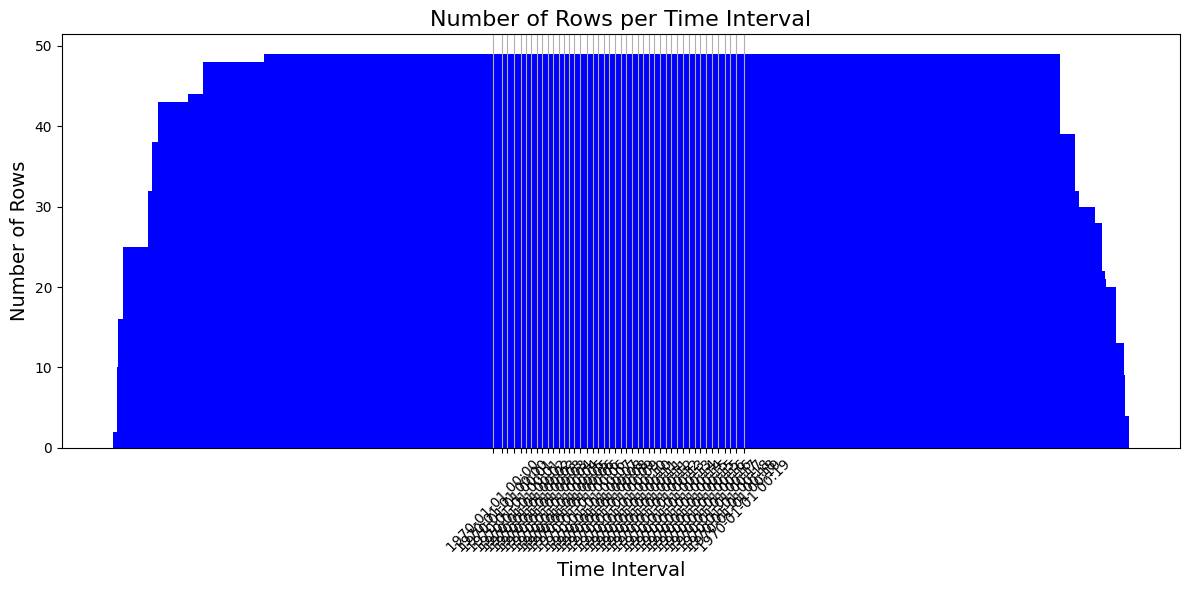

In [11]:
# Count the number of rows for each time interval
time_interval_counts = positions_links_df.groupby("time_bin").size()

# Plot the counts
plt.figure(figsize=(12, 6))
plt.bar(time_interval_counts.index, time_interval_counts.values, color='b', width=3600)  # Adjust width for better spacing
plt.title("Number of Rows per Time Interval", fontsize=16)
plt.xlabel("Time Interval", fontsize=14)
plt.ylabel("Number of Rows", fontsize=14)
plt.grid(axis='x')


x_labels = time_interval_counts.index[::24]  # Select every 24th interval
plt.xticks(x_labels, labels=pd.to_datetime(x_labels, unit='s').strftime('%Y-%m-%d %H:%M'), rotation=45)

plt.tight_layout()
plt.show()

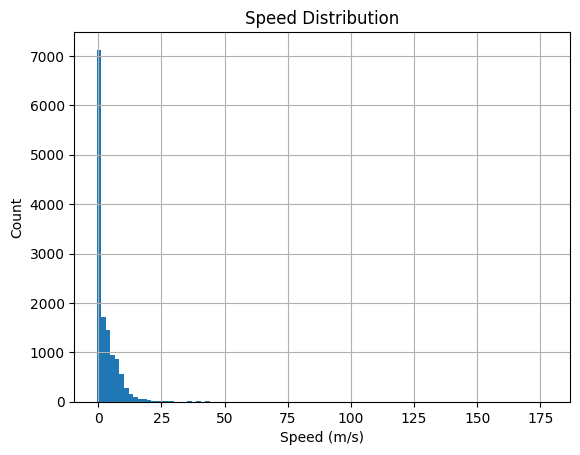

In [12]:
plt.hist(positions_links_df["speed"], bins=100)
plt.xlabel("Speed (m/s)")
plt.ylabel("Count")
plt.title("Speed Distribution")
plt.grid()
plt.show()

In [13]:
from torch_geometric_temporal.nn.recurrent import EvolveGCNH
from torch_geometric_temporal.nn.recurrent import GConvGRU


class MovementLinkPredictor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = GConvGRU(in_channels, out_channels, K=2)  # GCN neighborhood depth K=2


        self.decoder = nn.Sequential(
            nn.Linear(2 * out_channels, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )       
        
        # self.decoder = nn.Sequential(
        #     nn.Linear(2 * out_channels + edge_feat_dim, 64),
        #     nn.ReLU(),
        #     nn.Linear(64, 1),
        #     nn.Sigmoid()
        # )

        # MLP for edge feature context
        
        # self.edge_mlp = nn.Sequential(
        #     nn.Linear(edge_feat_dim + 1, 32),
        #     nn.ReLU(),
        #     nn.Linear(32, 1)
        # )


    def forward_encoder(self, x_seq, edge_index_seq):
        z = None
        for x, ei in zip(x_seq, edge_index_seq):
            if ei.size(1) == 0:
                continue
            z = self.encoder(x, ei)
        if z is None:
            raise ValueError("All time steps in this window are empty (no edges to learn from).")
        return z
    
    def forward_decoder(self, z, edge_index):
        src = z[edge_index[0]]
        dst = z[edge_index[1]]
        combined = torch.cat([src, dst], dim=1)  # shape: [num_edges, 2 * embedding_dim]
        return self.decoder(combined).squeeze(1)  # squeeze to [num_edges]
    
    
    # def forward_decoder(self, z, edge_index):
    #     src = z[edge_index[0]]
    #     dst = z[edge_index[1]]
    #     similarity = (src * dst).sum(dim=1)
    #     #context = self.edge_mlp(edge_feat).view(-1)
    #     #return torch.sigmoid(similarity + context)
    #     return torch.sigmoid(similarity)

    # def forward_decoder(self, z, edge_index, edge_feat):
    #     src = z[edge_index[0]]
    #     dst = z[edge_index[1]]
    #     combined = torch.cat([src, dst, edge_feat], dim=1)
    #     return self.decoder(combined).view(-1)





# class MovementLinkPredictor(nn.Module):
#     def __init__(self, in_channels, out_channels, num_nodes, edge_feat_dim):
#         super().__init__()
#         self.encoder = EvolveGCNH(in_channels, out_channels, num_nodes)
#         self.decoder = nn.Sequential(
#             nn.Linear(2 * out_channels + edge_feat_dim, 64),
#             nn.ReLU(),
#             nn.Linear(64, 1),
#             nn.Sigmoid()
#         )

#     def forward_encoder(self, x_seq, edge_index_seq, edge_weight_seq):
#         z = None
#         for x, ei, ew in zip(x_seq, edge_index_seq, edge_weight_seq):
#             if ei.size(1) == 0:
#                 continue  # Skip if no edges
#             z = self.encoder(x, ei, ew)
#         if z is None:
#             raise ValueError("All time steps in this window are empty (no edges to learn from).")
#         return z

#     def forward_decoder(self, z, edge_index, edge_feat):
#         src = z[edge_index[0]]
#         dst = z[edge_index[1]]
#         combined = torch.cat([src, dst, edge_feat], dim=1)
#         return self.decoder(combined).squeeze()



# class MovementLinkPredictor(torch.nn.Module):
#     def __init__(self, in_channels, out_channels, num_nodes):
#         super().__init__()
#         self.encoder = EvolveGCNH(in_channels=in_channels,      # number of input features per node
#                                   out_channels=out_channels,    # size of the embedding vector for each node
#                                   num_nodes=num_nodes)          # total number of nodes in the graph
    
#     def forward(self, x, edge_index, edge_weight):
#         z = self.encoder(x, edge_index, edge_weight)
#         return z

#     def decode(self, z, edge_index):
#         src = z[edge_index[0]]
#         dst = z[edge_index[1]]
#         score = (src * dst).sum(dim=-1)
#         return score

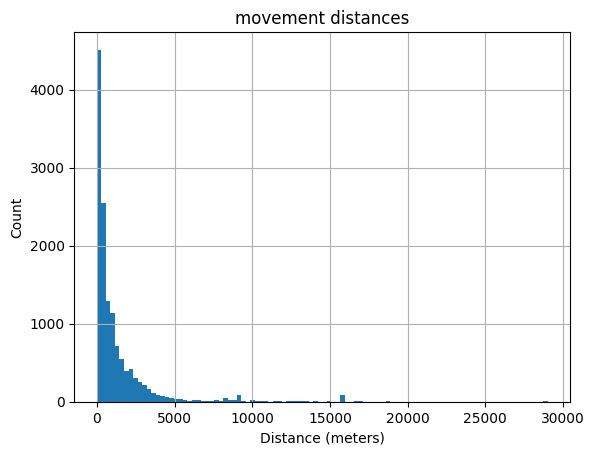

95th percentile distance: 4542.60 meters


In [14]:
from scipy.spatial.distance import euclidean

# computing distances of all movments

def compute_edge_distances(positions_links_df, coords_array):
    distances = []
    for _, row in positions_links_df.iterrows():
        src = int(row["prev_node_id"])
        dst = int(row["node_id"])
        dist = euclidean(coords_array[src], coords_array[dst])
        distances.append(dist)
    return distances

import matplotlib.pyplot as plt

coords_array = nodes_df[['node_x', 'node_y']].values
dists = compute_edge_distances(positions_links_df, coords_array)


plt.hist(dists, bins=100)
plt.xlabel("Distance (meters)")
plt.ylabel("Count")
plt.title("movement distances")
plt.grid()
plt.show()

threshold_95 = np.percentile(dists, 95)
print(f"95th percentile distance: {threshold_95:.2f} meters")

In [15]:
from scipy.spatial.distance import cdist

# storing distances between ALL nodes
dist_matrix = cdist(coords_array, coords_array, metric="euclidean")  # shape [num_nodes, num_nodes]
def get_edge_distances(edge_index, dist_matrix):
    src = edge_index[0].numpy()
    dst = edge_index[1].numpy()
    dists = dist_matrix[src, dst]
    return torch.tensor(dists, dtype=torch.float).unsqueeze(1)


In [16]:
# --- Negative Sampling with Distance---

def sample_spatial_negatives(pos_edge_index, dist_matrix, max_distance_meters, num_samples):
    num_nodes = dist_matrix.shape[0]
    pos_set = set((i.item(), j.item()) for i, j in zip(pos_edge_index[0], pos_edge_index[1]))

    neg_edges = set()
    attempts = 0
    max_attempts = 10 * num_samples

    while len(neg_edges) < num_samples and attempts < max_attempts:
        i = torch.randint(0, num_nodes, (1,)).item()
        j = torch.randint(0, num_nodes, (1,)).item()

        if (i, j) in pos_set or i == j:
            attempts += 1
            continue

        if dist_matrix[i, j] <= max_distance_meters:
            neg_edges.add((i, j))

        attempts += 1

    if not neg_edges:
        return torch.empty((2, 0), dtype=torch.long)

    src, dst = zip(*neg_edges)
    return torch.tensor([src, dst], dtype=torch.long)

In [17]:
# --- Random Negative Sampling (without taking distance into account) ---
def sample_negative_edges(pos_edge_index, num_nodes, num_samples):
    neg_edges = set()
    pos_set = set((i.item(), j.item()) for i, j in zip(pos_edge_index[0], pos_edge_index[1]))
    while len(neg_edges) < num_samples:
        i = torch.randint(0, num_nodes, (1,)).item()
        j = torch.randint(0, num_nodes, (1,)).item()
        if (i, j) not in pos_set:
            neg_edges.add((i, j))
    src, dst = zip(*neg_edges)
    return torch.tensor([src, dst], dtype=torch.long)

In [18]:
# --- Time-Stratified Split ---
def generate_stratified_split(all_bins, train_ratio=0.8, stride=3):
    train_bins = all_bins[::stride]
    test_bins = [b for b in all_bins if b not in train_bins]
    cutoff = int(len(train_bins) * train_ratio)
    return train_bins[:cutoff], test_bins

In [19]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau


# --- Setup ---
window_size = 5
embedding_dim = 64
learning_rate = 0.01
num_epochs = 60

num_nodes = features[0].shape[0]
for ef in edge_features:
    if ef.size(0) > 0:
        edge_feat_dim = ef.shape[1]
        break

all_bins = list(range(window_size, len(features) - 1))
train_bins, test_bins = generate_stratified_split(all_bins)

model = MovementLinkPredictor(
    in_channels=features[0].shape[1],   # 4 (node features)
    out_channels=embedding_dim         # 64
    #edge_feat_dim=edge_feat_dim         # 4 (hour, weekday, participant, speed)
)


optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, threshold=0.0005, verbose=True)


c:\Users\Michele\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [20]:
# setting a random seed for reproducibility
# (this will make sure that the results are the same every time the code is run even for random values)

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

In [21]:
import torch.nn.functional as F
import time

def timebin_to_hour_weekday(time_bin, interval_seconds, start_time_unix):
    timestamp = pd.to_datetime(start_time_unix + (time_bin * interval_seconds), unit="s")
    return timestamp.hour, timestamp.weekday()


def generate_edge_features(time_bin, num_edges):
    # using time_bin to compute timestamp directly
    hour, weekday = timebin_to_hour_weekday(time_bin, interval_seconds=interval, start_time_unix=start_time)

    participant_number = -1  # or 0
    speed_avg = positions_links_df["speed"].mean()                         # or a fallback like 1.0

    feat = torch.tensor([[hour, weekday, participant_number, speed_avg]], dtype=torch.float)
    return feat.repeat(num_edges, 1)

start_time_train = time.time()

# --- Training Loop ---
losses = []
for epoch in range(num_epochs):
    model.train()
    loss_sum = 0
    step_count = 0

    epoch_start = time.time()

    for t in train_bins:
        x_seq = features[t - window_size:t]
        ei_seq = edge_indices[t - window_size:t]
        ew_seq = edge_weights[t - window_size:t]

        if all(ei.size(1) == 0 for ei in ei_seq):
            continue  # skip time steps where the entire input window has no edges

        # for x, ei, ew in zip(x_seq, ei_seq, ew_seq):
        #     print("x.shape:", x.shape)
        #     print("ei.shape:", ei.shape)
        #     print("ew.shape:", ew.shape)
            
        z = model.forward_encoder(x_seq, ei_seq)

        pos_edge_index = targets[t]
        if pos_edge_index.size(1) == 0:
            continue

        # print(f"\t\t\t→ Time step: {t}, positive edges: {pos_edge_index.size(1)}")

        # edge_feat = generate_edge_features(t, pos_edge_index.size(1))
        # edge_feat = edge_features[t][:pos_edge_index.size(1)]
        
        #distances = get_edge_distances(pos_edge_index, dist_matrix)
        #edge_feat_with_dist = torch.cat([edge_feat, distances], dim=1)
        
        #pos_pred = model.forward_decoder(z, pos_edge_index, edge_feat)
        #pos_pred = model.forward_decoder(z, pos_edge_index, edge_feat_with_dist)
        pos_pred = model.forward_decoder(z, pos_edge_index)
        pos_label = torch.ones(pos_pred.size(0))

        neg_edge_index = sample_negative_edges(pos_edge_index, num_nodes, pos_pred.size(0))


        n_pos = pos_pred.size(0)
        neg_multiplier = 1

        n_neg = n_pos * neg_multiplier
        n_spatial = n_neg // 2
        n_random = n_neg - n_spatial  # handles odd case

        neg_spatial = sample_spatial_negatives(pos_edge_index, dist_matrix, 5000, n_spatial)
        neg_random = sample_negative_edges(pos_edge_index, num_nodes, n_random)

        neg_edge_index = torch.cat([neg_spatial, neg_random], dim=1)        
        #edge_feat_neg = generate_edge_features(t, neg_edge_index.size(1))
        #distances_neg = get_edge_distances(neg_edge_index, dist_matrix)
        #edge_feat_neg_with_dist = torch.cat([edge_feat_neg, distances_neg], dim=1)  

        #neg_pred = model.forward_decoder(z, neg_edge_index, edge_feat_neg)
        #neg_pred = model.forward_decoder(z, neg_edge_index, edge_feat_neg_with_dist)
        neg_pred = model.forward_decoder(z, neg_edge_index)
        neg_label = torch.zeros(neg_pred.size(0))

        all_preds = torch.cat([pos_pred, neg_pred])
        all_labels = torch.cat([pos_label, neg_label])

        loss = F.binary_cross_entropy(all_preds, all_labels, reduction='mean')

        #print(f"  ⤷ pos_pred: {pos_pred.mean().item():.4f}, neg_pred: {neg_pred.mean().item():.4f}, loss: {loss.item():.4f}")


        optimizer.zero_grad()
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        loss_sum += loss.item()
        step_count += 1
    
    avg_loss = loss_sum / step_count
    losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{num_epochs},\t\tTraining Loss: {avg_loss:.4f},\t\tTime: {time.time() - epoch_start:.2f}s")
    scheduler.step(avg_loss)
    for param_group in optimizer.param_groups:
        print(f"  ⤷ LR: {param_group['lr']:.6f}")




end_time = time.time()
print(f"\nTotal training time: {(end_time - start_time_train):.2f} seconds")



Epoch 1/60,		Training Loss: 0.6511,		Time: 27.88s
  ⤷ LR: 0.010000
Epoch 2/60,		Training Loss: 0.6398,		Time: 28.33s
  ⤷ LR: 0.010000
Epoch 3/60,		Training Loss: 0.6129,		Time: 28.81s
  ⤷ LR: 0.010000
Epoch 4/60,		Training Loss: 0.6112,		Time: 26.20s
  ⤷ LR: 0.010000
Epoch 5/60,		Training Loss: 0.6055,		Time: 27.48s
  ⤷ LR: 0.010000
Epoch 6/60,		Training Loss: 0.5962,		Time: 31.94s
  ⤷ LR: 0.010000
Epoch 7/60,		Training Loss: 0.5826,		Time: 30.24s
  ⤷ LR: 0.010000
Epoch 8/60,		Training Loss: 0.5371,		Time: 36.57s
  ⤷ LR: 0.010000
Epoch 9/60,		Training Loss: 0.5278,		Time: 28.50s
  ⤷ LR: 0.010000
Epoch 10/60,		Training Loss: 0.4821,		Time: 28.94s
  ⤷ LR: 0.010000
Epoch 11/60,		Training Loss: 0.4422,		Time: 35.11s
  ⤷ LR: 0.010000
Epoch 12/60,		Training Loss: 0.4417,		Time: 28.38s
  ⤷ LR: 0.010000
Epoch 13/60,		Training Loss: 0.4315,		Time: 27.97s
  ⤷ LR: 0.010000
Epoch 14/60,		Training Loss: 0.4640,		Time: 26.79s
  ⤷ LR: 0.010000
Epoch 15/60,		Training Loss: 0.4462,		Time: 26.73s
  ⤷ LR

In [25]:
np.save("D:/Desktop/MSc Thesis/scripts/losses/loss_9.npy", np.array(losses))

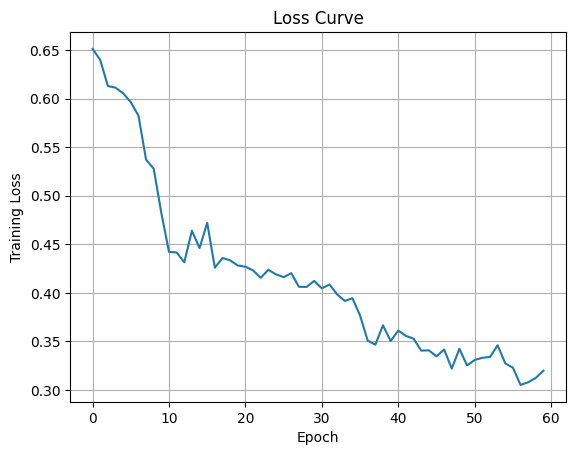

In [22]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss Curve")
plt.grid()
plt.show()

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from collections import defaultdict


def evaluate(model, features, edge_indices, targets, edge_features, test_bins, num_nodes):
    hour_metrics = defaultdict(list)
    day_metrics = defaultdict(list)
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for t in test_bins:
            hour, weekday = timebin_to_hour_weekday(t, interval, start_time)

            x_seq = features[t - window_size:t]
            ei_seq = edge_indices[t - window_size:t]

            if all(ei.size(1) == 0 for ei in ei_seq):
                continue

            z = model.forward_encoder(x_seq, ei_seq)
            pos_edge_index = targets[t]
            if pos_edge_index.size(1) == 0:
                continue

            #edge_feat = edge_features[t][:pos_edge_index.size(1)]
            #distances = get_edge_distances(pos_edge_index, dist_matrix)
            #edge_feat_with_dist = torch.cat([edge_feat, distances], dim=1)


            #pos_pred = model.forward_decoder(z, pos_edge_index, edge_feat)
            #pos_pred = model.forward_decoder(z, pos_edge_index, edge_feat_with_dist)
            pos_pred = model.forward_decoder(z, pos_edge_index)


            y_true += [1] * pos_pred.size(0)
            y_pred += pos_pred.tolist()

            hour_metrics[hour].extend(zip([1] * pos_pred.size(0), pos_pred.tolist()))
            day_metrics[weekday].extend(zip([1] * pos_pred.size(0), pos_pred.tolist()))

            neg_edge_index = sample_negative_edges(pos_edge_index, num_nodes, pos_pred.size(0))
            #edge_feat_neg = generate_edge_features(t, neg_edge_index.size(1))
            #distances_neg = get_edge_distances(neg_edge_index, dist_matrix)
            #edge_feat_neg_with_dist = torch.cat([edge_feat_neg, distances_neg], dim=1)


            #neg_pred = model.forward_decoder(z, neg_edge_index, edge_feat_neg)
            #neg_pred = model.forward_decoder(z, neg_edge_index, edge_feat_neg_with_dist)
            neg_pred = model.forward_decoder(z, neg_edge_index)

            y_true += [0] * neg_pred.size(0)
            y_pred += neg_pred.tolist()

            hour_metrics[hour].extend(zip([0] * neg_pred.size(0), neg_pred.tolist()))
            day_metrics[weekday].extend(zip([0] * neg_pred.size(0), neg_pred.tolist()))

    y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]
    print("\nEvaluation on Test Bins:")
    print("Accuracy:", accuracy_score(y_true, y_pred_binary))
    print("Precision:", precision_score(y_true, y_pred_binary, zero_division=0))
    print("Recall:", recall_score(y_true, y_pred_binary, zero_division=0))
    print("AUC:", roc_auc_score(y_true, y_pred))

In [24]:
evaluate(model, features, edge_indices, targets, edge_features, test_bins, num_nodes)

# print("\nAccuracy per hour of day:")
# for h in sorted(hour_metrics):
#     labels, preds = zip(*hour_metrics[h])
#     binary_preds = [1 if p > 0.5 else 0 for p in preds]
#     acc = accuracy_score(labels, binary_preds)
#     print(f"  Hour {h:02d}: Accuracy = {acc:.3f}")

# print("\nAccuracy per day of week:")
# for d in sorted(day_metrics):
#     labels, preds = zip(*day_metrics[d])
#     binary_preds = [1 if p > 0.5 else 0 for p in preds]
#     acc = accuracy_score(labels, binary_preds)
#     print(f"  Day {d}: Accuracy = {acc:.3f}")


Evaluation on Test Bins:
Accuracy: 0.8748646893266941
Precision: 0.8884900157056316
Recall: 0.8573284260662482
AUC: 0.9496015931166397


# __OLD__

In [28]:
edge_indices = []
edge_weights = []
features = []
targets = []

num_nodes = len(nodes_df)

# grouped by time step (1 hour)
grouped = positions_links_df.groupby('time_interval')

for interval, group in grouped:
    source_nodes = torch.tensor(group['prev_node_id'].values, dtype=torch.long)
    target_nodes = torch.tensor(group['node_id'].values, dtype=torch.long)
    speed = torch.tensor(group['speed'].values, dtype=torch.float)
    edge_index = torch.stack([source_nodes, target_nodes], dim=0)

    edge_indices.append(edge_index)

    edge_weights.append(torch.ones(edge_index.size(1)))

# for link prediction, future edges are the targets
for t in range(len(edge_indices) - 1):
    targets.append(edge_indices[t + 1])

In [33]:
print(len(edge_indices[:-1]))
print(len(features[:-1]))
print(len(targets))


1038
0
1038


In [34]:
dataset = DynamicGraphTemporalSignal(
    edge_indices=edge_indices[:-1],
    edge_weights=edge_weights[:-1],
    targets=targets,
)

TypeError: DynamicGraphTemporalSignal.__init__() missing 1 required positional argument: 'features'

In [ ]:
# node structure is static
# node features are static (for now - later dynamic with weather features)

# edge structure is dynamic (new edges)

In [ ]:
edge_indices = []
edge_attrs = []

for t in time_bins:
    snapshot = positions_links_df[positions_links_df["time_bin"] == t]
    
    # Convert edges to COO format
    edge_index = np.array([snapshot["prev_node_id"].values, snapshot["node_id"].values])
    
    # Edge attributes (participant ID, speed)
    edge_attr = np.array(snapshot[['id_participant', 'speed', 'merged_datetime']].values, dtype=np.float32)

    edge_indices.append(edge_index)
    edge_attrs.append(edge_attr)


In [ ]:
node_features = torch.tensor(nodes_df.drop(columns=['node_id']).values, dtype=torch.float)
#node_positions = torch.tensor(nodes_df[['node_x', 'node_y']].values, dtype=torch.float)

In [ ]:
dataset = DynamicGraphStaticSignal(
    edge_indices=edge_indices,
    edge_weights=edge_attrs,
    features=node_features
)

True

In [52]:
import torch_geometric_temporal

ModuleNotFoundError: No module named 'torch_geometric_temporal'

In [3]:
# edge connectivity in COO format
edge_index = torch.tensor(
    np.vstack([
        positions_links_df["prev_node_id"].values,
        positions_links_df["node_id"].values
    ]),
    dtype=torch.long
)
#edge attributes
edge_attr = torch.tensor(
    np.vstack([
        positions_links_df['id_participant'].values,
        positions_links_df['speed'].values
    ]).T,
    dtype=torch.float
)

In [ ]:
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, pos=node_positions)
data.validate(raise_on_error=True)

In [6]:
#initializing the target as an array filled with zeors
# three dimensional with shape (n of edges, n of nodes, n of node features)
target = np.zeros((len(positions_links_df), len(nodes_df), node_features.shape[1]))

for i, row in positions_links_df.iterrows():
    node_idx = int(row["node_id"])
    target[i, node_idx, :] = node_features[node_idx].numpy()

target = torch.tensor(target, dtype=torch.float)

In [11]:
timestamps = positions_links_df["timestamp"].unique()  # Use actual timestamps as recorded
num_timesteps = len(timestamps)
num_nodes = len(nodes_df)
num_features = node_features.shape[1]

target = np.zeros((num_timesteps, num_nodes, num_features))

# Populate the target tensor with node features at each timestamp
for i, timestamp in enumerate(timestamps):
    rows_at_time = positions_links_df[positions_links_df["timestamp"] == timestamp]
    for _, row in rows_at_time.iterrows():
        node_idx = row["node_id"].astype(int)
        target[i, node_idx, :] = node_features[node_idx].numpy()

target = torch.tensor(target, dtype=torch.float)

In [32]:
print("Edge index shape:", edge_index.shape)
print("Unique nodes in edge_index:", torch.unique(edge_index).shape[0])

Edge index shape: torch.Size([2, 13489])
Unique nodes in edge_index: 3823


In [12]:
test_dataset_st = SpatioTemporalDataset(
    target = target,  # includes time, nodes, and features
    index=positions_links_df["merged_datetime"],
    connectivity=(edge_index, torch.ones(edge_index.shape[1])),  # Graph structure
    window=12,
    horizon=1
)

In [13]:
print (test_dataset_st)

SpatioTemporalDataset(n_samples=13305, n_nodes=13489, n_channels=5)


In [ ]:
# number of steps to predict
k = 5

target_columns = [column for column in positions_links_df.columns if column.startswith]

In [10]:
from torch_geometric.utils import dense_to_sparse

# Convert `edge_index` and `edge_attr` into a valid adjacency matrix
adj_matrix = torch.zeros((len(nodes_df), len(nodes_df)))
adj_matrix[edge_index[0], edge_index[1]] = edge_attr[:, 0]  # Assuming first edge attribute is weight

# Convert to sparse format
sparse_edge_index, sparse_edge_attr = dense_to_sparse(adj_matrix)

# ✅ Create dataset with correct `connectivity`
dataset_st = SpatioTemporalDataset(
    target=positions_links_df["node_id"].values,
    index=positions_links_df["merged_datetime"],
    connectivity=(sparse_edge_index, sparse_edge_attr),  # ✅ Graph structure with edge attributes
    covariates={  # ✅ Include node and edge attributes here
        "participant_id": positions_links_df["id_participant"].values,
        "speed": positions_links_df["speed"].values,
        "node_features": node_features.numpy(),  # ✅ Add node features here
    },
    window=12,
    horizon=1
)

NameError: name 'node_features' is not defined

In [ ]:
node_features = torch.tensor(nodes_df[['node_x', 'node_y']].values, dtype=torch.long)
edge_index = torch.tensor([positions_links_df['prev_node_id'].values, positions_links_df['node_id'].values], dtype=torch.long)
edge_attr = torch.tensor(
    np.vstack([
        positions_links_df['id_participant'].values,
        positions_links_df['timestamp'].values,
        positions_links_df['speed'].values
    ]).T,
    dtype=torch.float
)


In [ ]:
DatetimeDataset.similarity_options.add(None)

target = positions_links_df[['node_id']].astype(int)
target.index = pd.MultiIndex.from_frame(positions_links_df[['merged_datetime', 'node_id']]) 

dataset_ts = DatetimeDataset(
    target=positions_links_df[['node_id']],  
    covariates={},                                  # i can put the node weather values and the sinusoidal time encoding here
    freq=None,
    sort_index=True,
    force_synchronization=True,                     # might need to look into this
    similarity_score=None
)


In [ ]:
print(dataset_ts)
print("Number of nodes in dataset:", dataset_ts.n_nodes)

print("\nTarget Preview:")
print(dataset_ts.target.head())

print("\nCovariates Keys:")
print(dataset_ts.covariates.keys())

print("\nFirst Few Time Steps:")
print(dataset_ts.index[:5])

In [ ]:
target = positions_links_df[['node_id']]

print(target.index[:5])  # Should show timestamps
print(target.columns)  # Should show ['node_id']
print(target.shape)  # Should match expected (num_time_steps, num_features)

In [ ]:
print(dataset_ts.target.shape)
print("Unique nodes in dataset:", positions_links_df["node_id"].nunique())


